In [1]:
import tensorflow as tf
import numpy as np

#one hot encodes the classification as well as appends the gender class
def combineData(person,gender):
    one_hot = np.zeros((len(person),7))
    for i in range(len(person)):
        one_hot[i][person[i]] = 1
        one_hot[i][6] = gender[i]
    return one_hot
        
#copied from assignment
def data_segmentation(data_path, target_path, task):
# task = 0 >> select the name ID targets for face recognition task
# task = 1 >> select the gender ID targets for gender recognition task 
    data = np.load(data_path)/255
    data = np.reshape(data, [-1, 32*32])
    target = np.load(target_path)
    np.random.seed(45689)
    rnd_idx = np.arange(np.shape(data)[0])
    np.random.shuffle(rnd_idx)
    trBatch = int(0.8*len(rnd_idx))
    validBatch = int(0.1*len(rnd_idx))
    trainData, validData, testData = data[rnd_idx[1:trBatch],:], \
                                     data[rnd_idx[trBatch+1:trBatch + validBatch],:],\
                                     data[rnd_idx[trBatch + validBatch+1:-1],:]
    trainTarget, validTarget, testTarget = target[rnd_idx[1:trBatch], task], \
                                target[rnd_idx[trBatch+1:trBatch + validBatch], task],\
                                target[rnd_idx[trBatch + validBatch + 1:-1], task]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

_, _, _, trainTarget0, validTarget0, testTarget0 = data_segmentation("data_facescrub.npy",
                                                                    "target_facescrub.npy",0)

trainData, validData, testData, trainTarget1, validTarget1, testTarget1 = data_segmentation("data_facescrub.npy",
                                                                                         "target_facescrub.npy",1)
trainTarget = combineData(trainTarget0,trainTarget1)
validTarget = combineData(validTarget0,validTarget1)
testTarget = combineData(testTarget0,testTarget1)

In [2]:
"""This helper function calculates the test accuracy given the trained weights and bias"""
def accuracy(predictions,labels):
    correctly_predicted=0
    m=predictions.shape[0] 
    
    gender_correct = np.sum(np.around(predictions[:,6])==labels[:,6])
        
    #remove gender label
    gender_acc = gender_correct/m
    predictions = np.delete(predictions,6,1)
    labels = np.delete(labels,6,1)
    correctly_predicted = 0
    temp = np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
    correctly_predicted = correctly_predicted+temp
    
    #twice the size because we counted twice
    face_acc = (correctly_predicted) / m
    return (gender_acc+face_acc)/2


In [21]:
def start_train(n_iterations,learning_rate,decaybias,isAdam,batch_size):
    n = 32
    k = 32
    n_epoch = int(n_iterations*batch_size/trainData.shape[0])
    
    #Data Handler
    valid_accuracy_log = np.zeros(n_epoch)
    valid_entropy= np.zeros(n_epoch)
    train_accuracy_log = np.zeros(n_epoch)
    train_entropy = np.zeros(n_epoch)
    
    #Test Data
    x_in = tf.placeholder(tf.float32,[None,n*k], name="dataset_in")
    y_in = tf.placeholder(tf.float32, [None,7], name="true_value")

    #Weights
    w = tf.Variable(tf.zeros([n*k, 7], dtype=np.float32), name="weight")
    b = tf.Variable(tf.zeros([7], dtype=np.float32), name="bias")
    
    #optimizer
    if isAdam:
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    else:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
        
    #train Loss functions
    y_pred = tf.add(tf.matmul(x_in,w),b)
    loss_weight_decay=decaybias*tf.nn.l2_loss(w) 
    train_cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits= y_pred,labels = y_in)
    loss = tf.reduce_mean(tf.add(train_cross_entropy,loss_weight_decay))

    #for accuracy logging
    prediction = tf.sigmoid(tf.add(tf.matmul(x_in,w),b))
    #Train
    train = optimizer.minimize(loss)
    
    #initialized all vars
    init = tf.global_variables_initializer()
    
    #run!
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(n_epoch):
            #clear our history (we use this to calculate the average accuracy/loss for each iteration)
            entropy_history = 0
            accuracy_history = 0
            #reshuffles the dataset in unison. for each epoch
            rng_state = np.random.get_state()
            np.random.shuffle(trainData)
            np.random.set_state(rng_state)
            np.random.shuffle(trainTarget)
            #batches of batch_size up to total number of datapoints (3500)
            for offset in range(0, trainData.shape[0], batch_size):
                #find the proper dataset
                batch_x = trainData[offset:offset+batch_size]
                batch_y = trainTarget[offset:offset+batch_size]
                #train
                sess.run((train),feed_dict={x_in:batch_x.reshape(-1,n*k),y_in:batch_y})
                #add to history
                entropy_history = entropy_history + sess.run(loss,feed_dict={x_in:batch_x.reshape(-1,n*k),y_in:batch_y})
                y_hat = sess.run(prediction,feed_dict={x_in:batch_x.reshape(-1,n*k)})
                accuracy_history= accuracy_history + accuracy(y_hat,batch_y)    
            #calculate and store the average history for that iteration
            train_entropy[epoch] = entropy_history/(trainData.shape[0]/batch_size)
            #divide by round((trainData.shape[0]/batch_size)) = 3 reason explained in doc
            train_accuracy_log[epoch] = accuracy_history/3
            #store validation data
            y_hat = sess.run(prediction,feed_dict={x_in:validData})           
            valid_accuracy_log[epoch] = accuracy(y_hat,validTarget)
            valid_entropy[epoch] = sess.run(loss,feed_dict={x_in:validData,y_in:validTarget})
            
        #evaluate test data
        y_hat = sess.run(prediction,feed_dict={x_in:testData})           
        test_accuracy = accuracy(y_hat,testTarget)
        return train_entropy,train_accuracy_log,valid_accuracy_log,valid_entropy,test_accuracy

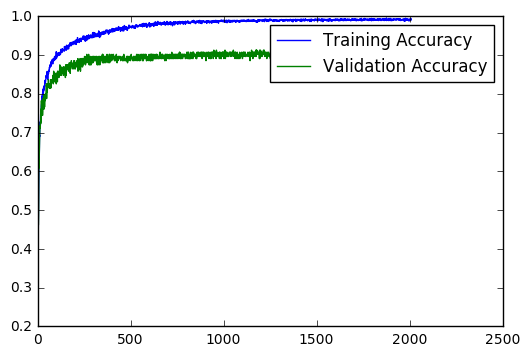

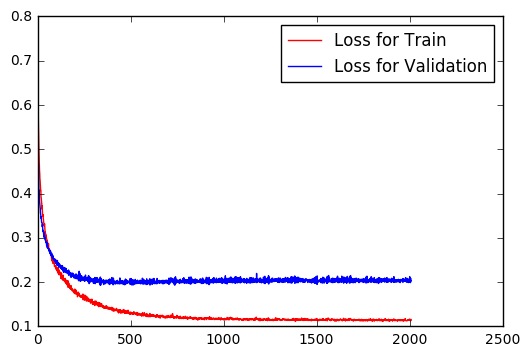

accuracy= 0.9193548387096775


In [39]:
train_entropy,train_accuracy_log,valid_accuracy_log,valid_entropy,test_accuracy = start_train(5000,0.005,0.0001,True,300)
import matplotlib.pyplot as p 
p.plot(train_accuracy_log, label="Training Accuracy")
p.plot(valid_accuracy_log,label="Validation Accuracy")
p.legend(numpoints = 1)
p.show() 
p.plot(train_entropy,'r-',label ="Loss for Train")
p.plot(valid_entropy,'b-',label="Loss for Validation")
p.legend(numpoints = 1)
p.show()
print("accuracy=",test_accuracy)

In [34]:
"""DID NOT WORK: learning rate and weight decay tuner 
I found Lrate = 0.005 with Wdecay = 0.0001 to be pretty good with 92% test accuracy. 
I found it via manual implementations"""
learning_rate = 0.001
weight_decay = 0.0005
learning_rate_history = []
accuracy_history = []
temp=[]
answer = [0,0]
adder = 0.001
for i in range(5):
    learning_rate_history.append(learning_rate)
    for j in range(5):
        temp.append(weight_decay)
        _,acc,_,_,_ = start_train(5000,learning_rate,weight_decay,True,300)
        accuracy_history.append(acc)
        if(np.max(acc)<temp[j]):
            answer[1] = weight_decay
            temp = []
            break
        weight_decay = weight_decay+adder
    if (np.max(acc) < learning_rate_history[i]):
        answer[0] = learning_rate
        break
    learning_rate = learning_rate + adder     
    
print(answer)

[0, 0]
